<a href="https://www.kaggle.com/code/sonujha090/global-wheat-detection-pytorch?scriptVersionId=115151706" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Aim: To Create A Pipeline For Object Detection With Pytorch

## Importing the necessary Libraries

In [1]:
# Download TorchVision repo to use some files from
# references/detection
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 273274, done.
remote: Counting objects: 100% (12475/12475), done.
remote: Compressing objects: 100% (597/597), done.
remote: Total 273274 (delta 11895), reused 12408 (delta 11854), pack-reused 260799
Receiving objects: 100% (273274/273274), 546.66 MiB | 35.10 MiB/s, done.
Resolving deltas: 100% (249640/249640), done.
fatal: not a git repository (or any parent up to mount point /kaggle)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [2]:
import torch, torchvision
from torch.utils.data import Dataset, DataLoader

In [3]:
import numpy as np 
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ast 
from PIL import Image
import os 

# Data Preprocessing

In [4]:
path = Path('/kaggle/input/global-wheat-detection')

In [5]:
df = pd.read_csv(path/'train.csv')
df.shape

(147793, 5)

In [6]:
df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [7]:
cvt2list = lambda x: ast.literal_eval(x) 
df['bbox'] = df['bbox'].apply(cvt2list)

In [8]:
conv = lambda x: [x[0], x[1], x[0]+x[2], x[1]+x[3]]
df['bbox'] = df['bbox'].apply(conv)

In [9]:
df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 890.0, 258.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 356.0, 606.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 451.0, 664.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 943.0, 202.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 150.0, 261.0]",usask_1


**Unique Images**

In [10]:
df_processed= df.groupby('image_id')['bbox'].apply(list).reset_index(name='bboxes')

In [11]:
df_processed.head()

,image_id,bboxes
0,00333207f,"[[0, 654, 37, 765], [0, 817, 135, 915], [0, 19..."
1,005b0d8bb,"[[765.0, 879.0, 881.0, 958.0], [84.0, 539.0, 2..."
2,006a994f7,"[[437.0, 988.0, 535.0, 1024.0], [309.0, 527.0,..."
3,00764ad5d,"[[89.0, 256.0, 202.0, 363.0], [216.0, 282.0, 3..."
4,00b5fefed,"[[709.0, 97.0, 913.0, 202.0], [775.0, 250.0, 9..."


**Splitting the dataset into train and valid set**

In [12]:
from sklearn.model_selection import train_test_split

# Split the data into independent and dependent variables
X = df_processed.drop(columns=['bboxes'])
y = df_processed['bboxes']

# Split the data into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the train and validation dataframes
train_df = pd.concat([X_train, y_train], axis=1)
valid_df = pd.concat([X_valid, y_valid], axis=1)
train_df.shape, valid_df.shape

((2698, 2), (675, 2))

In [13]:
# taking a small sample for experiment
train_df = train_df.sample(frac=0.1)
valid_df = valid_df.sample(frac=0.1)
train_df.shape, valid_df.shape

((270, 2), (68, 2))

# Pytorch DataLoader

In [14]:
class WheatDataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.df = df
        self.root = Path(root)
        self.transforms = transform
        self.image_ids = self.df.image_id.unique()
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_id, bboxes = self.df.iloc[idx]
        img_path = os.path.join(self.root, img_id+'.jpg')
        img = Image.open(img_path)
        boxes = []
        areas = []
        for bbox in bboxes:
            x0 = bbox[0]
            y0 = bbox[1]
            x1 = bbox[2]
            y1 = bbox[3]
            boxes.append([x0, y0, x1, y1])
            areas.append((x1-x0)*(y1-y0))
            
        boxes = np.array(boxes)
        boxes = torch.tensor(bboxes, dtype=torch.float32)
        areas= torch.tensor(areas)
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        target = {'boxes': boxes, 'labels':torch.ones(len(boxes), dtype=torch.int64), 'image_id':torch.tensor(idx), 'area': areas, 'iscrowd': iscrowd}

        if self.transforms is not None:
            img = self.transforms(img)
            
        return img, target

In [15]:
ds = WheatDataset(train_df, path/'train')

# Visualize a dataset

In [16]:
def plot_bboxes(img, target):
    # Get the image and bounding box information
    image = img
    bboxes = target['boxes']
    category_idx = target['labels']
    category_names = ['0', '1']

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10,10))
    

    # Display the image
    ax.imshow(image)

    # Add a bounding box for each object in the image
    for bbox, idx in zip(bboxes, category_idx):
        x, y, width, height = bbox
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
#         ax.text(x, y, category_names[idx], color='w', fontsize=12, bbox=dict(facecolor='r', alpha=0.5))

    plt.show()

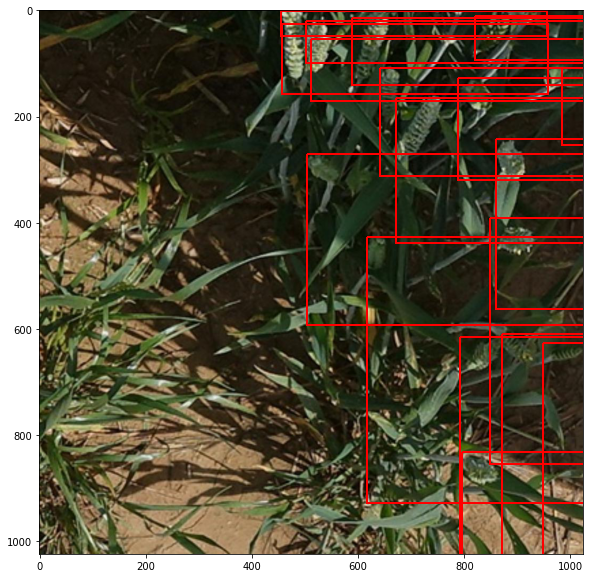

In [17]:
img, target = ds[1]
plot_bboxes(img, target)

**Transform**

In [18]:
import torchvision.transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [19]:
train_ds = WheatDataset(train_df, path/'train', transform=get_transform(train=True))
valid_ds = WheatDataset(valid_df, path/'train', transform=get_transform(train=False))

**DataLoader**

In [20]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dl = DataLoader(train_ds, collate_fn=collate_fn, batch_size=8)
valid_dl = DataLoader(valid_ds, collate_fn=collate_fn, batch_size=8)

# Model

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)


num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

**Testing on one batch**

In [23]:
images, targets = next(iter(train_dl))

for images, targets in train_dl:

    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    loss_dict = model(images, targets)
    print(loss_dict)
    break

{'loss_classifier': tensor(0.8281, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.3806, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(3.7778, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.1746, device='cuda:0', grad_fn=<DivBackward0>)}


**Hyperparameter**

In [24]:
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# Training

In [25]:
import math
import sys
import time

import torch
import torchvision.models.detection.mask_rcnn
import utils
from coco_eval import CocoEvaluator
from coco_utils import get_coco_api_from_dataset


def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, scaler=None):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

#         lr_scheduler = torch.optim.lr_scheduler.linear_lr(
#             optimizer, start_factor=warmup_factor, total_iters=warmup_iters
#         )
    lr_scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=10
    )

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return 

In [26]:
%%time 

# training for 5 epochs
from engine import evaluate
num_epochs = 2

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, train_dl, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, valid_dl, device=device)

Epoch: [0]  [ 0/34]  eta: 0:01:26  lr: 0.005000  loss: 5.2776 (5.2776)  loss_classifier: 0.8312 (0.8312)  loss_box_reg: 0.3588 (0.3588)  loss_objectness: 3.8967 (3.8967)  loss_rpn_box_reg: 0.1909 (0.1909)  time: 2.5335  data: 0.2620  max mem: 9753
Epoch: [0]  [10/34]  eta: 0:00:45  lr: 0.000500  loss: 1.7860 (2.0974)  loss_classifier: 0.5298 (0.5443)  loss_box_reg: 0.5752 (0.5645)  loss_objectness: 0.5213 (0.8442)  loss_rpn_box_reg: 0.1399 (0.1444)  time: 1.8817  data: 0.3185  max mem: 10023
Epoch: [0]  [20/34]  eta: 0:00:26  lr: 0.000050  loss: 1.7331 (1.9174)  loss_classifier: 0.5140 (0.5314)  loss_box_reg: 0.5840 (0.5807)  loss_objectness: 0.4716 (0.6569)  loss_rpn_box_reg: 0.1373 (0.1484)  time: 1.8248  data: 0.3236  max mem: 10023
Epoch: [0]  [30/34]  eta: 0:00:07  lr: 0.000005  loss: 1.6805 (1.8380)  loss_classifier: 0.5089 (0.5246)  loss_box_reg: 0.5866 (0.5898)  loss_objectness: 0.4222 (0.5785)  loss_rpn_box_reg: 0.1373 (0.1451)  time: 1.8490  data: 0.3249  max mem: 10023
Epoch

In [27]:
# Saving the model
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')

In [28]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return T.ToPILImage()(img).convert('RGB')


# Testing on one image

In [29]:
# pick one image from the test set
img, target = valid_ds[5]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))

predicted #boxes:  100


In [30]:
def plot_bboxes(img, target):
    # Get the image and bounding box information
    image = img
    bboxes = target['boxes'].cpu()
    category_idx = target['labels'].cpu()
    category_names = ['0', '1']

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10,10))
    

    # Display the image
    ax.imshow(image)

    # Add a bounding box for each object in the image
    for bbox, idx in zip(bboxes, category_idx):
        x, y, width, height = bbox
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
#         ax.text(x, y, category_names[idx], color='w', fontsize=12, bbox=dict(facecolor='r', alpha=0.5))

    plt.show()

MODEL OUTPUT


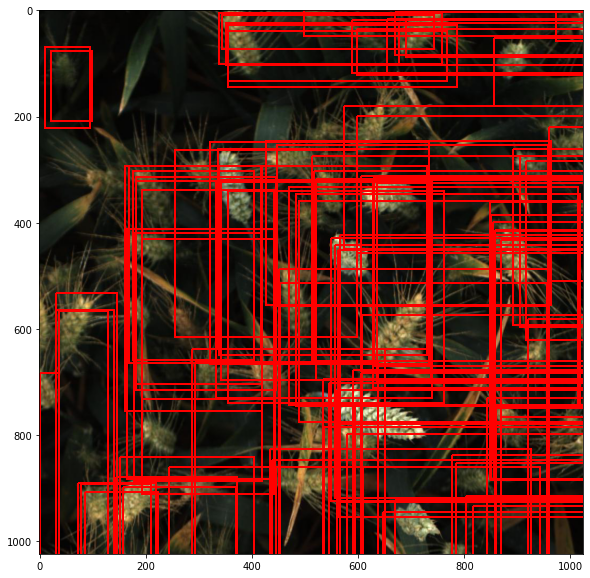

In [31]:
print('MODEL OUTPUT')

plot_bboxes(torch_to_pil(img), prediction)

NMS APPLIED MODEL OUTPUT


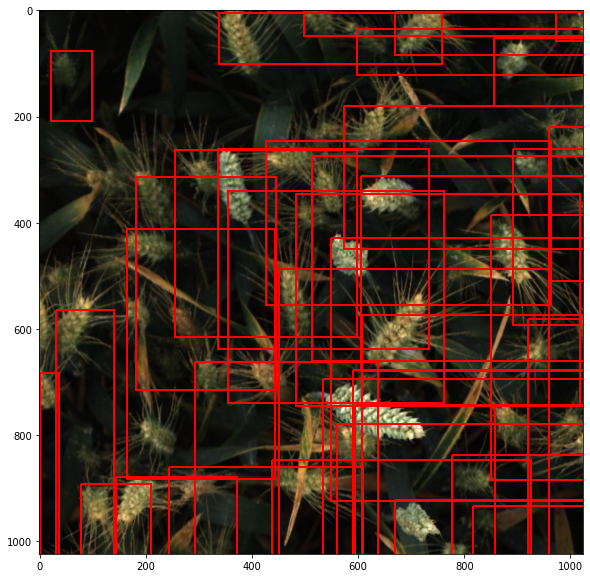

In [32]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
print('NMS APPLIED MODEL OUTPUT')
plot_bboxes(torch_to_pil(img), nms_prediction)

# Inference Kernal

**https://www.kaggle.com/code/sonujha090/submission-fasterrcnn/**